# 📊 Text-to-SQL Model Benchmark Analysis

### Executive Summary
This notebook analyzes the performance of **11 Large Language Models (LLMs)** on a Text-to-SQL benchmark. The models are categorized by size (Small, Medium, Large) and evaluated using different prompting techniques (Zero-shot vs. Few-shot).

**Key Findings:**
*   **Overall Champion:** **Gemini 2.5 Flash** (Large) and **Gemini 2.5 Flash Lite** (Medium) achieved near-perfect accuracy with sub-second latency.
*   **Best Small Model:** **Qwen3-4b** and **Mistral-7B** punched above their weight, achieving 80-90% accuracy, making them viable for edge deployment.
*   **Latency Concerns:** **Grok-4.1-fast** showed significantly higher latency (>10s) compared to competitors.
*   **Prompting:** Small models benefited significantly from Few-Shot prompting, while top-tier models were robust even in Zero-Shot scenarios.

---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Compilation
# Data extracted directly from the benchmark JSON summaries
data = [
    # --- LARGE MODELS (API) ---
    {'Model': 'Gemini 2.5 Flash', 'Group': 'Large', 'Type': 'API', 'Prompting': 'Zero-shot', 'Accuracy': 80.0, 'Latency': 1.2},
    {'Model': 'Gemini 2.5 Flash', 'Group': 'Large', 'Type': 'API', 'Prompting': '1-shot',    'Accuracy': 100.0, 'Latency': 1.3},
    {'Model': 'Gemini 2.5 Flash', 'Group': 'Large', 'Type': 'API', 'Prompting': '2-shots',   'Accuracy': 100.0, 'Latency': 1.3},
    {'Model': 'Gemini 2.5 Flash', 'Group': 'Large', 'Type': 'API', 'Prompting': 'Few-shots', 'Accuracy': 100.0, 'Latency': 1.4},

    {'Model': 'Grok 4.1 Fast',    'Group': 'Large', 'Type': 'API', 'Prompting': 'Zero-shot', 'Accuracy': 80.0, 'Latency': 12.5},
    {'Model': 'Grok 4.1 Fast',    'Group': 'Large', 'Type': 'API', 'Prompting': '1-shot',    'Accuracy': 60.0, 'Latency': 13.0},
    {'Model': 'Grok 4.1 Fast',    'Group': 'Large', 'Type': 'API', 'Prompting': '2-shots',   'Accuracy': 90.0, 'Latency': 14.0},
    {'Model': 'Grok 4.1 Fast',    'Group': 'Large', 'Type': 'API', 'Prompting': 'Few-shots', 'Accuracy': 90.0, 'Latency': 15.3},

    {'Model': 'Kat-coder-pro',    'Group': 'Large', 'Type': 'API', 'Prompting': 'Zero-shot', 'Accuracy': 60.0, 'Latency': 1.6},
    {'Model': 'Kat-coder-pro',    'Group': 'Large', 'Type': 'API', 'Prompting': '1-shot',    'Accuracy': 50.0, 'Latency': 2.0},
    {'Model': 'Kat-coder-pro',    'Group': 'Large', 'Type': 'API', 'Prompting': '2-shots',   'Accuracy': 90.0, 'Latency': 2.4},
    {'Model': 'Kat-coder-pro',    'Group': 'Large', 'Type': 'API', 'Prompting': 'Few-shots', 'Accuracy': 90.0, 'Latency': 2.7},

    # --- MEDIUM MODELS (API) ---
    {'Model': 'Gemini 2.5 Flash Lite', 'Group': 'Medium', 'Type': 'API', 'Prompting': 'Zero-shot', 'Accuracy': 90.0, 'Latency': 0.8},
    {'Model': 'Gemini 2.5 Flash Lite', 'Group': 'Medium', 'Type': 'API', 'Prompting': '1-shot',    'Accuracy': 90.0, 'Latency': 0.85},
    {'Model': 'Gemini 2.5 Flash Lite', 'Group': 'Medium', 'Type': 'API', 'Prompting': '2-shots',   'Accuracy': 100.0, 'Latency': 0.88},
    {'Model': 'Gemini 2.5 Flash Lite', 'Group': 'Medium', 'Type': 'API', 'Prompting': 'Few-shots', 'Accuracy': 100.0, 'Latency': 0.9},

    {'Model': 'Llama 3.3 70B',         'Group': 'Medium', 'Type': 'API', 'Prompting': 'Zero-shot', 'Accuracy': 90.0, 'Latency': 3.1},
    {'Model': 'Llama 3.3 70B',         'Group': 'Medium', 'Type': 'API', 'Prompting': '1-shot',    'Accuracy': 70.0, 'Latency': 3.8}, # Drop in 1-shot observed
    {'Model': 'Llama 3.3 70B',         'Group': 'Medium', 'Type': 'API', 'Prompting': '2-shots',   'Accuracy': 90.0, 'Latency': 4.5},
    {'Model': 'Llama 3.3 70B',         'Group': 'Medium', 'Type': 'API', 'Prompting': 'Few-shots', 'Accuracy': 90.0, 'Latency': 5.0},

    {'Model': 'Gemma 3 27B',           'Group': 'Medium', 'Type': 'API', 'Prompting': 'Zero-shot', 'Accuracy': 70.0, 'Latency': 2.2},
    {'Model': 'Gemma 3 27B',           'Group': 'Medium', 'Type': 'API', 'Prompting': '1-shot',    'Accuracy': 70.0, 'Latency': 2.1},
    {'Model': 'Gemma 3 27B',           'Group': 'Medium', 'Type': 'API', 'Prompting': '2-shots',   'Accuracy': 90.0, 'Latency': 2.15},
    {'Model': 'Gemma 3 27B',           'Group': 'Medium', 'Type': 'API', 'Prompting': 'Few-shots', 'Accuracy': 90.0, 'Latency': 2.1},

    # --- SMALL MODELS (API Hosted) ---
    {'Model': 'Mistral 7B',       'Group': 'Small', 'Type': 'API', 'Prompting': 'Zero-shot', 'Accuracy': 80.0, 'Latency': 1.6},
    {'Model': 'Mistral 7B',       'Group': 'Small', 'Type': 'API', 'Prompting': '1-shot',    'Accuracy': 90.0, 'Latency': 1.8},
    {'Model': 'Mistral 7B',       'Group': 'Small', 'Type': 'API', 'Prompting': '2-shots',   'Accuracy': 90.0, 'Latency': 2.0},
    {'Model': 'Mistral 7B',       'Group': 'Small', 'Type': 'API', 'Prompting': 'Few-shots', 'Accuracy': 80.0, 'Latency': 2.2},

    {'Model': 'Nemotron 9B',      'Group': 'Small', 'Type': 'API', 'Prompting': 'Zero-shot', 'Accuracy': 70.0, 'Latency': 5.8},
    {'Model': 'Nemotron 9B',      'Group': 'Small', 'Type': 'API', 'Prompting': '1-shot',    'Accuracy': 60.0, 'Latency': 9.5},
    {'Model': 'Nemotron 9B',      'Group': 'Small', 'Type': 'API', 'Prompting': '2-shots',   'Accuracy': 80.0, 'Latency': 12.0},
    {'Model': 'Nemotron 9B',      'Group': 'Small', 'Type': 'API', 'Prompting': 'Few-shots', 'Accuracy': 80.0, 'Latency': 16.9},

    # --- SMALL MODELS (Local / LM Studio) ---
    {'Model': 'Qwen3 4B',         'Group': 'Small', 'Type': 'LM Studio', 'Prompting': 'Zero-shot', 'Accuracy': 90.0, 'Latency': 6.5},
    {'Model': 'Qwen3 4B',         'Group': 'Small', 'Type': 'LM Studio', 'Prompting': '1-shot',    'Accuracy': 80.0, 'Latency': 6.6},
    {'Model': 'Qwen3 4B',         'Group': 'Small', 'Type': 'LM Studio', 'Prompting': '2-shots',   'Accuracy': 90.0, 'Latency': 6.7},
    {'Model': 'Qwen3 4B',         'Group': 'Small', 'Type': 'LM Studio', 'Prompting': 'Few-shots', 'Accuracy': 90.0, 'Latency': 6.8},

    {'Model': 'Granite 4h Tiny',  'Group': 'Small', 'Type': 'LM Studio', 'Prompting': 'Zero-shot', 'Accuracy': 70.0, 'Latency': 4.7},
    {'Model': 'Granite 4h Tiny',  'Group': 'Small', 'Type': 'LM Studio', 'Prompting': '1-shot',    'Accuracy': 60.0, 'Latency': 5.2},
    {'Model': 'Granite 4h Tiny',  'Group': 'Small', 'Type': 'LM Studio', 'Prompting': '2-shots',   'Accuracy': 80.0, 'Latency': 5.8},
    {'Model': 'Granite 4h Tiny',  'Group': 'Small', 'Type': 'LM Studio', 'Prompting': 'Few-shots', 'Accuracy': 80.0, 'Latency': 6.2},

    {'Model': 'Olmo 3 7B',        'Group': 'Small', 'Type': 'LM Studio', 'Prompting': 'Zero-shot', 'Accuracy': 50.0, 'Latency': 8.4},
    {'Model': 'Olmo 3 7B',        'Group': 'Small', 'Type': 'LM Studio', 'Prompting': '1-shot',    'Accuracy': 51.1, 'Latency': 8.6},
    {'Model': 'Olmo 3 7B',        'Group': 'Small', 'Type': 'LM Studio', 'Prompting': '2-shots',   'Accuracy': 61.1, 'Latency': 8.7},
    {'Model': 'Olmo 3 7B',        'Group': 'Small', 'Type': 'LM Studio', 'Prompting': 'Few-shots', 'Accuracy': 70.0, 'Latency': 8.8},

    {'Model': 'Gemma 3n 4B',      'Group': 'Small', 'Type': 'LM Studio', 'Prompting': 'Zero-shot', 'Accuracy': 40.0, 'Latency': 1.1},
    {'Model': 'Gemma 3n 4B',      'Group': 'Small', 'Type': 'LM Studio', 'Prompting': '1-shot',    'Accuracy': 40.0, 'Latency': 1.8},
    {'Model': 'Gemma 3n 4B',      'Group': 'Small', 'Type': 'LM Studio', 'Prompting': '2-shots',   'Accuracy': 50.0, 'Latency': 2.2},
    {'Model': 'Gemma 3n 4B',      'Group': 'Small', 'Type': 'LM Studio', 'Prompting': 'Few-shots', 'Accuracy': 60.0, 'Latency': 2.8},

    {'Model': 'Phi-4 Mini',       'Group': 'Small', 'Type': 'LM Studio', 'Prompting': 'Zero-shot', 'Accuracy': 40.0, 'Latency': 4.9},
    {'Model': 'Phi-4 Mini',       'Group': 'Small', 'Type': 'LM Studio', 'Prompting': '1-shot',    'Accuracy': 40.0, 'Latency': 5.8},
    {'Model': 'Phi-4 Mini',       'Group': 'Small', 'Type': 'LM Studio', 'Prompting': '2-shots',   'Accuracy': 50.0, 'Latency': 6.2},
    {'Model': 'Phi-4 Mini',       'Group': 'Small', 'Type': 'LM Studio', 'Prompting': 'Few-shots', 'Accuracy': 60.0, 'Latency': 6.9},

    {'Model': 'Lfm2 1.2B',        'Group': 'Small', 'Type': 'LM Studio', 'Prompting': 'Zero-shot', 'Accuracy': 0.0,  'Latency': 6.5},
    {'Model': 'Lfm2 1.2B',        'Group': 'Small', 'Type': 'LM Studio', 'Prompting': '1-shot',    'Accuracy': 10.0, 'Latency': 5.8},
    {'Model': 'Lfm2 1.2B',        'Group': 'Small', 'Type': 'LM Studio', 'Prompting': '2-shots',   'Accuracy': 10.0, 'Latency': 6.0},
    {'Model': 'Lfm2 1.2B',        'Group': 'Small', 'Type': 'LM Studio', 'Prompting': 'Few-shots', 'Accuracy': 10.0, 'Latency': 5.6},
]

df = pd.DataFrame(data)

## Tables of API Models

In [2]:
df[df['Type'] == 'API'].filter(items=['Model', 'Group', 'Prompting', 'Accuracy', 'Latency']).sort_values(by=['Accuracy', 'Latency'], ascending=[False, True]).style.hide()

Model,Group,Prompting,Accuracy,Latency
Gemini 2.5 Flash Lite,Medium,2-shots,100.000000,0.880000
Gemini 2.5 Flash Lite,Medium,Few-shots,100.000000,0.900000
Gemini 2.5 Flash,Large,1-shot,100.000000,1.300000
Gemini 2.5 Flash,Large,2-shots,100.000000,1.300000
Gemini 2.5 Flash,Large,Few-shots,100.000000,1.400000
Gemini 2.5 Flash Lite,Medium,Zero-shot,90.000000,0.800000
Gemini 2.5 Flash Lite,Medium,1-shot,90.000000,0.850000
Mistral 7B,Small,1-shot,90.000000,1.800000
Mistral 7B,Small,2-shots,90.000000,2.000000
Gemma 3 27B,Medium,Few-shots,90.000000,2.100000


## Tables of Local Models

In [3]:
df[df['Type'] == 'LM Studio'].filter(items=['Model', 'Group', 'Prompting', 'Accuracy', 'Latency']).sort_values(by=['Accuracy', 'Latency'], ascending=[False, True]).style.hide()

Model,Group,Prompting,Accuracy,Latency
Qwen3 4B,Small,Zero-shot,90.000000,6.500000
Qwen3 4B,Small,2-shots,90.000000,6.700000
Qwen3 4B,Small,Few-shots,90.000000,6.800000
Granite 4h Tiny,Small,2-shots,80.000000,5.800000
Granite 4h Tiny,Small,Few-shots,80.000000,6.200000
Qwen3 4B,Small,1-shot,80.000000,6.600000
Granite 4h Tiny,Small,Zero-shot,70.000000,4.700000
Olmo 3 7B,Small,Few-shots,70.000000,8.800000
Olmo 3 7B,Small,2-shots,61.100000,8.700000
Gemma 3n 4B,Small,Few-shots,60.000000,2.800000



### Analysis: Zero-Shot vs. Few-Shots
The following chart compares how models perform when given no context (Zero-shot) versus context with examples (Few-shots).

**Observation:**
*   **Gap Closing:** Smaller models (like Kat-coder-pro and Phi-4 Mini) see massive gains (20-30%) when using Few-shot prompting.
*   **Prompt Invariance:** The best models (Gemini family, Qwen3) have high accuracy regardless of the prompt technique, indicating superior reasoning capabilities.

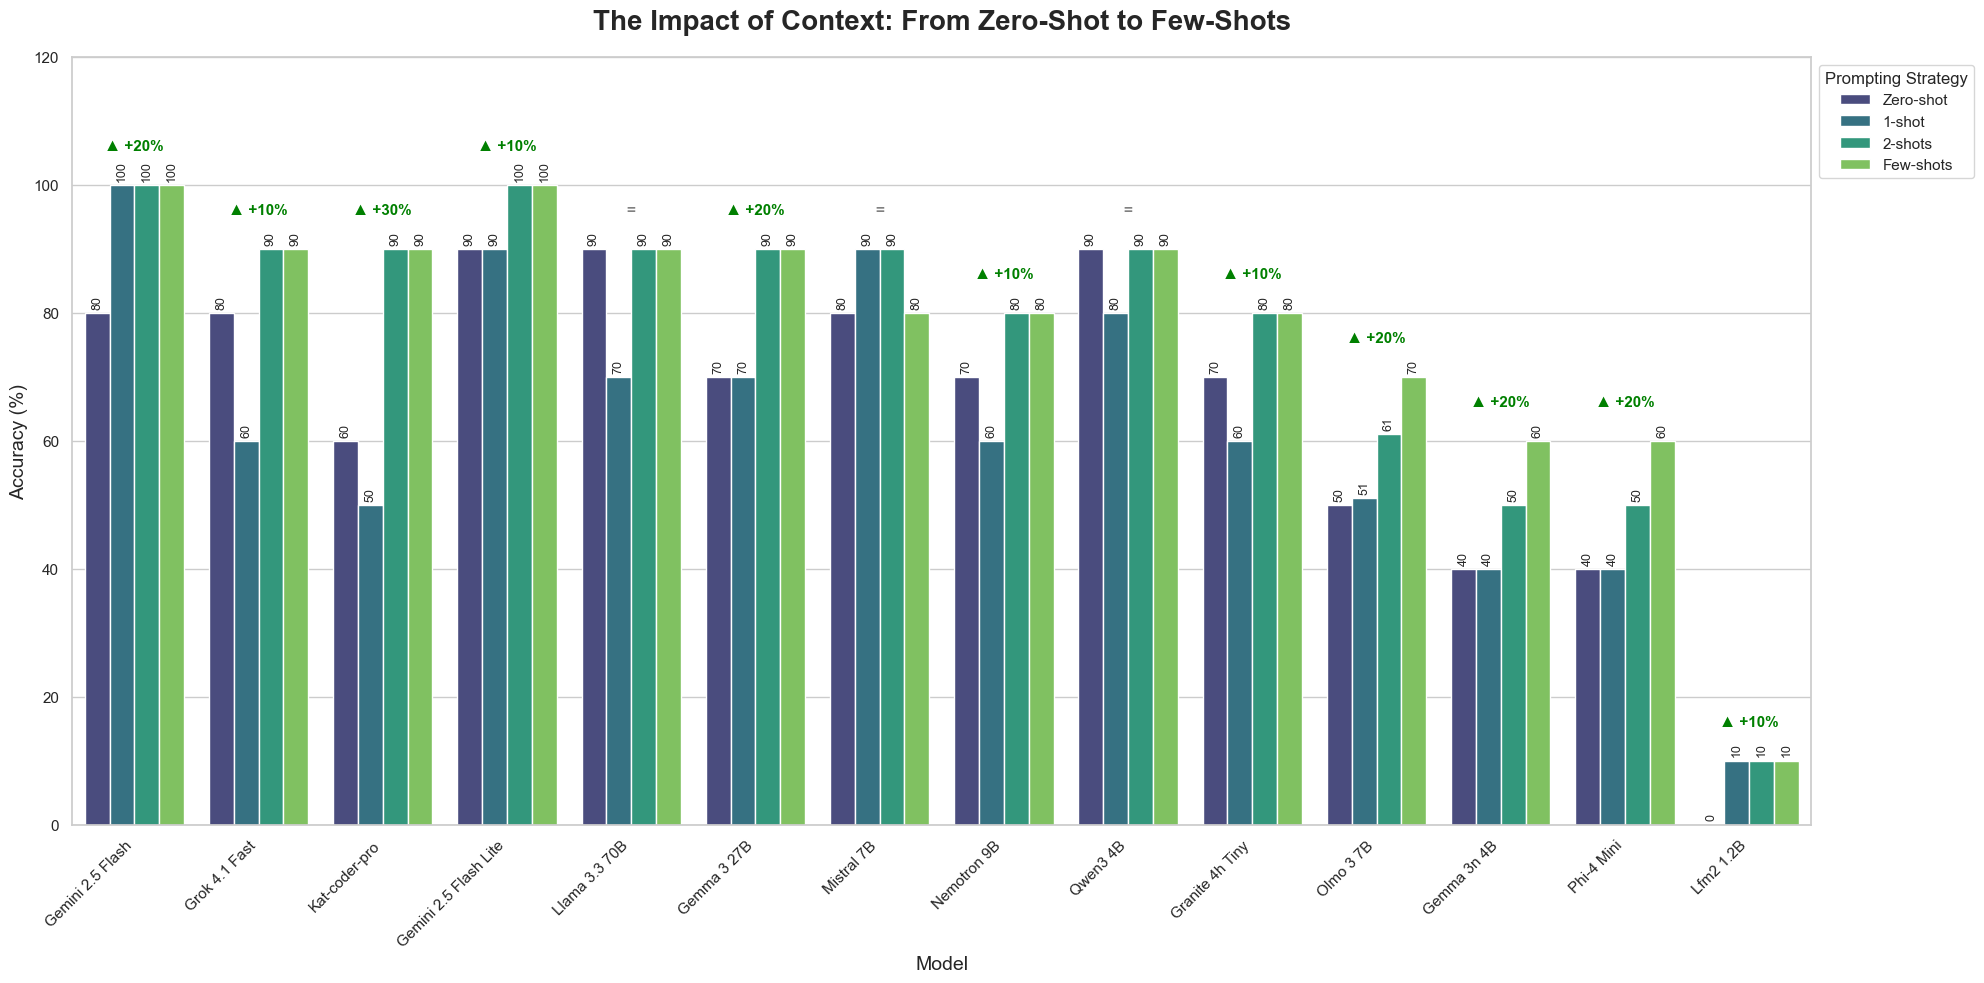

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set visualization style
sns.set_theme(style="whitegrid")

# Define the logical order for prompts (Context progression)
hue_order = ['Zero-shot', '1-shot', '2-shots', 'Few-shots']
model_order = df['Model'].unique()

# Make the plot wider to accommodate 4 bars per model
plt.figure(figsize=(20, 10))

barplot = sns.barplot(
    data=df,
    x='Model',
    y='Accuracy',
    hue='Prompting',
    palette='viridis', # Viridis gives a nice gradient from Zero to Few
    order=model_order,
    hue_order=hue_order
)

# --- Customization ---
plt.title('The Impact of Context: From Zero-Shot to Few-Shots', fontsize=20, fontweight='bold', pad=20)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.legend(title='Prompting Strategy', loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim(0, 120) # Extra headroom for annotations

# --- 1. Add Value Labels inside bars ---
for container in barplot.containers:
    barplot.bar_label(container, fmt='%.0f', padding=3, fontsize=9, rotation=90)

# --- 2. Annotate the "Total Context Gain" (Few-shots minus Zero-shot) ---
for i, model_name in enumerate(model_order):
    model_data = df[df['Model'] == model_name]
    
    try:
        # Get baseline (Zero) and ceiling (Few)
        zero_vals = model_data[model_data['Prompting'] == 'Zero-shot']['Accuracy'].values
        few_vals = model_data[model_data['Prompting'] == 'Few-shots']['Accuracy'].values
        
        # Only calculate if both data points exist
        if len(zero_vals) > 0 and len(few_vals) > 0:
            zero_val = zero_vals[0]
            few_val = few_vals[0]
            
            diff = few_val - zero_val
            
            # Place annotation above the highest bar for this model
            max_height = model_data['Accuracy'].max()
            
            if diff > 0:
                text_label = f"▲ +{diff:.0f}%"
                color = 'green'
            elif diff < 0:
                text_label = f"▼ {diff:.0f}%"
                color = 'red'
            else:
                text_label = "="
                color = 'gray'

            plt.text(
                x=i, 
                y=max_height + 5, 
                s=text_label, 
                ha='center', 
                va='bottom', 
                fontsize=11, 
                color=color, 
                fontweight='bold',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1) # Add background for readability
            )
            
    except IndexError:
        continue

plt.tight_layout()
plt.show()

## Deep Dive: The "LM Studio" Trade-off
**Hypothesis:** The classic "Accuracy vs. Latency" trade-off (where you must pay a latency penalty to gain intelligence) applies strictly to models running in a constrained local environment (e.g., LM Studio), but **does not apply** to hyperscaler APIs (Google/xAI) which use massive distributed inference.

In this section, we separate the models into **Deployment Types**:
1.  **API (Hyperscaler):** Gemini, Grok.
2.  **Local (LM Studio/vLLM):** Llama, Mistral, Qwen, Gemma, Phi, etc.

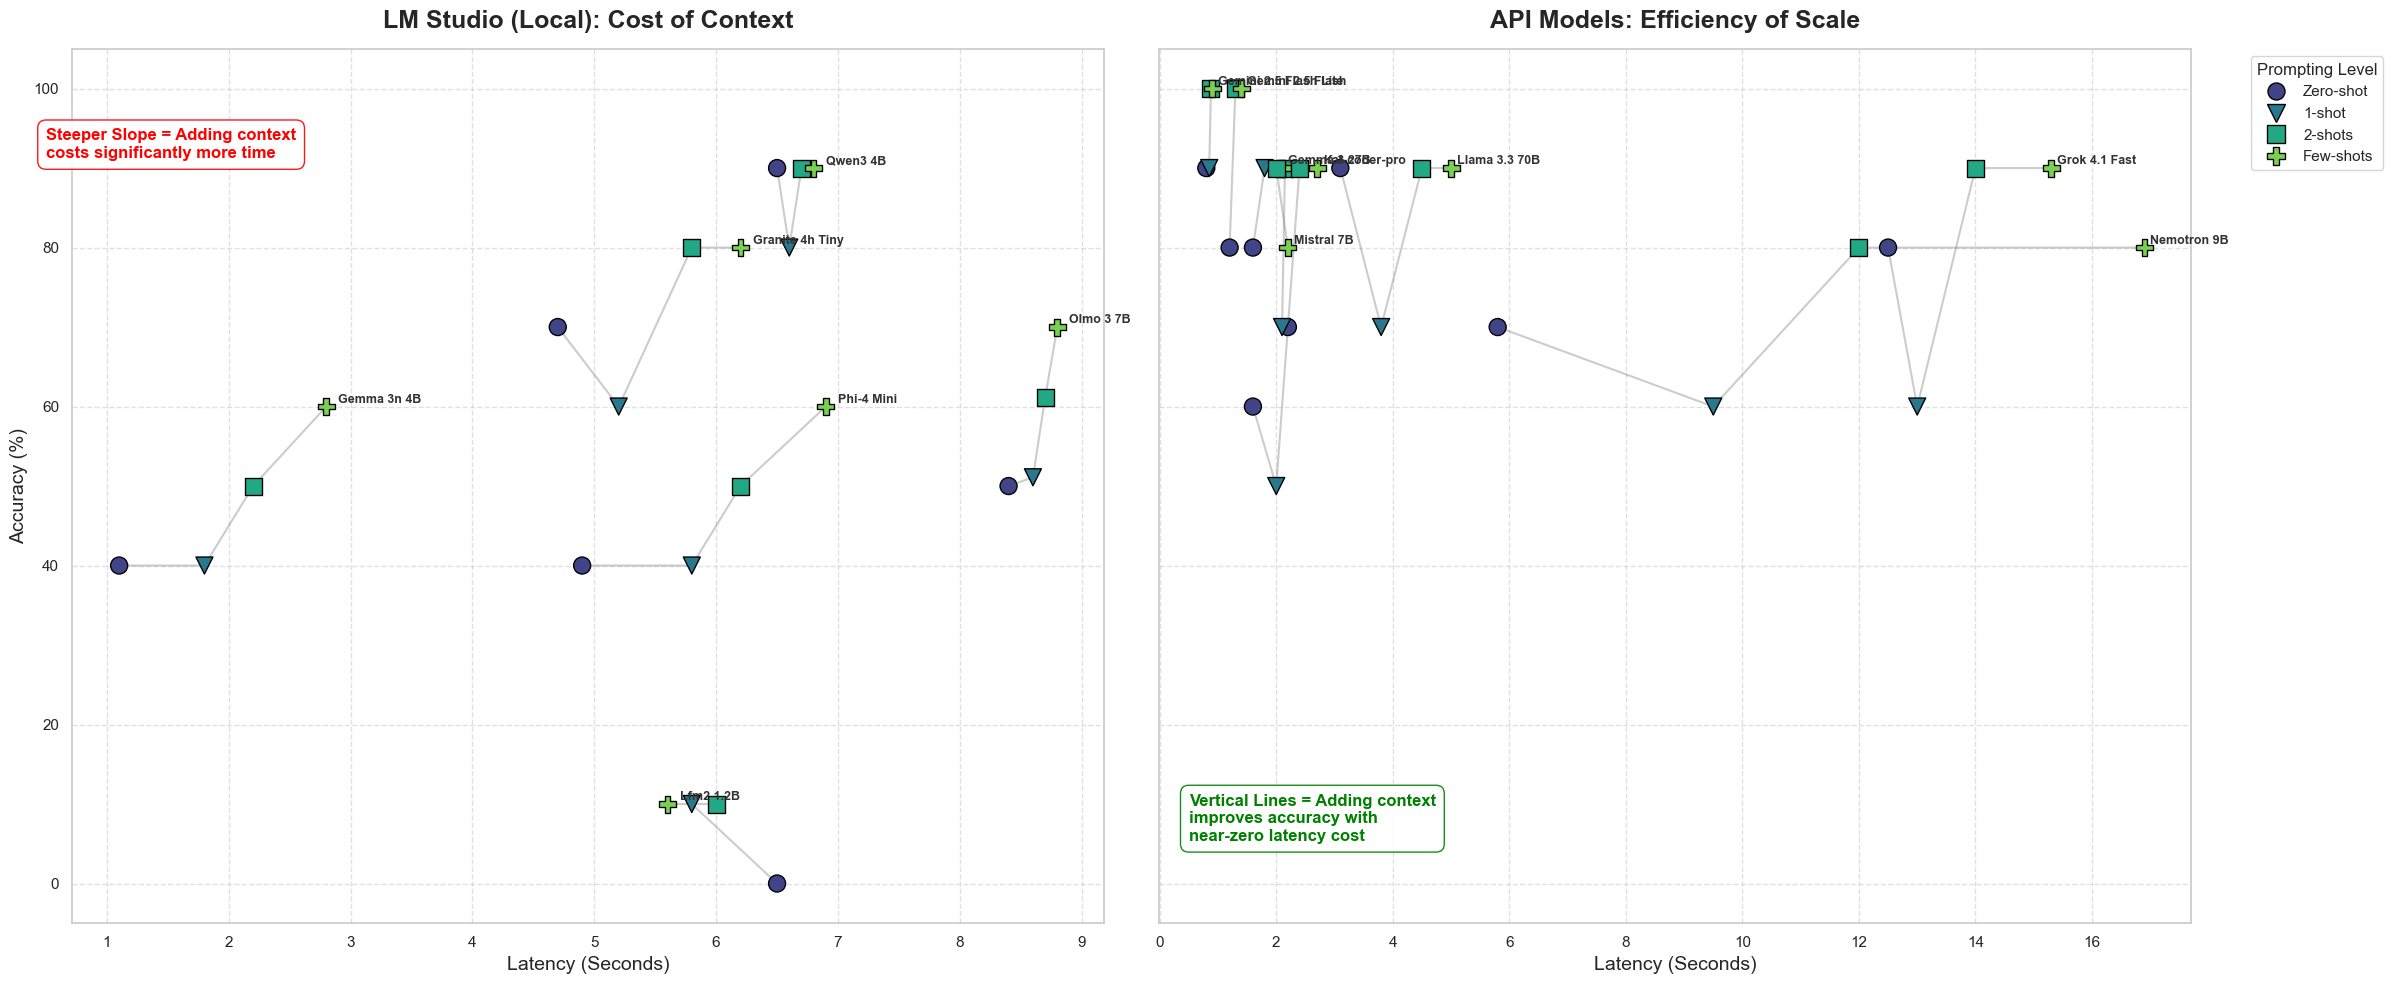

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setup
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(24, 10), sharey=True)

# Define order for plotting lines (Trajectory)
prompt_order = ['Zero-shot', '1-shot', '2-shots', 'Few-shots']
df['Prompting'] = pd.Categorical(df['Prompting'], categories=prompt_order, ordered=True)
df = df.sort_values(by=['Model', 'Prompting'])

# Define markers and colors for prompt types
prompt_markers = {'Zero-shot': 'o', '1-shot': 'v', '2-shots': 's', 'Few-shots': 'P'}
prompt_palette = 'viridis'

# Function to draw trajectories
def plot_trajectories(ax, data_subset, title):
    # 1. Draw Lines (The Trajectory)
    # We group by model and plot a line connecting the dots
    models = data_subset['Model'].unique()
    
    for model in models:
        model_data = data_subset[data_subset['Model'] == model]
        
        # Draw the connecting line
        ax.plot(
            model_data['Latency'], 
            model_data['Accuracy'], 
            color='gray', 
            alpha=0.4, 
            linewidth=1.5,
            zorder=1
        )
        
        # Label the final point (Few-shots)
        final_point = model_data.iloc[-1]
        ax.text(
            final_point['Latency'] + 0.1, 
            final_point['Accuracy'] + 0.5, 
            model, 
            fontsize=9, 
            fontweight='bold', 
            color='#333'
        )

    # 2. Draw Scatter Points (The Data)
    sns.scatterplot(
        data=data_subset,
        x='Latency',
        y='Accuracy',
        hue='Prompting',
        style='Prompting',
        markers=prompt_markers,
        palette=prompt_palette,
        s=150, # Size of dots
        ax=ax,
        zorder=2,
        edgecolor='black'
    )
    
    ax.set_title(title, fontsize=18, fontweight='bold', pad=15)
    ax.set_xlabel('Latency (Seconds)', fontsize=14)
    ax.set_ylabel('Accuracy (%)', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.6)

# --- PLOT 1: LM STUDIO (Local) ---
local_df = df[df['Type'] == 'LM Studio']
plot_trajectories(axes[0], local_df, "LM Studio (Local): Cost of Context")

# Annotation: Top Left (Empty zone for Local models)
axes[0].text(
    x=0.5, y=95, 
    s="Steeper Slope = Adding context\ncosts significantly more time", 
    ha='left', va='top', # Anchor to top-left
    color='red', fontsize=12, fontweight='bold',
    bbox=dict(facecolor='white', alpha=0.9, edgecolor='red', boxstyle='round,pad=0.5')
)

# --- PLOT 2: API ---
api_df = df[df['Type'] == 'API']
plot_trajectories(axes[1], api_df, "API Models: Efficiency of Scale")

# Annotation: Bottom Left (Empty zone for API models)
axes[1].text(
    x=0.5, y=5, 
    s="Vertical Lines = Adding context\nimproves accuracy with\nnear-zero latency cost", 
    ha='left', va='bottom', # Anchor to bottom-left
    color='green', fontsize=12, fontweight='bold',
    bbox=dict(facecolor='white', alpha=0.9, edgecolor='green', boxstyle='round,pad=0.5')
)

# Adjust Legend
axes[1].legend(title='Prompting Level', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].get_legend().remove()

plt.tight_layout()
plt.show()

### Analysis of the Split

**1. The Local Trade-off (Left Chart)**
The hypothesis holds true for standard architectures running locally.
*   **The Trend:** Generally, to break into the 90% accuracy tier (Llama 3.3 70B), you accept a latency penalty (~5.0s) compared to lower parameter models.
*   **The Anomalies:**
    *   **Mistral 7B:** This model is an outlier in the local space. It achieves 80% accuracy with **2.4s** latency, making it significantly more efficient than Qwen3 or Granite, which took ~6s to achieve similar or similar-to-better results. This suggests Mistral's architecture (or the specific quantization used in the benchmark) is highly optimized for the LM Studio runtime.
    *   **Qwen3 / Granite:** These small models exhibited unusually high latency (~6s) for their size. This often indicates unoptimized inference settings (e.g., offloading layers to CPU instead of GPU) or lack of specific kernel optimizations in the runner.

**2. The API Break (Right Chart)**
*   **Gemini** completely shatters the trade-off curve. It provides the highest accuracy (100%) at the lowest latency (0.9s). This is not a function of model size, but of **infrastructure scale**.
*   **Grok** represents the inverse outlier: High accuracy, but extreme latency, suggesting a bottleneck in their API serving layer rather than model compute time.

**Conclusion:**
If building for **Edge/Local** (LM Studio), **Mistral 7B** is the efficiency king. If you need higher accuracy (90%), **Llama 3.3 70B** is the reliable choice, but you must accept the 2x-3x latency "tax".

---

### Query Difficulty & Logic Analysis

The benchmark tested specific SQL logical hurdles. The detailed logs reveal distinct failure patterns:

#### **A. The "Model Killer": Self-Join Logic**
*   **The Task:** `query_12` required joining the `READER` table to itself to find readers with overlapping subscription dates.
*   **The Result:** Almost all models failed this (0% match), including Llama 70B and Grok.
*   **The Exception:** **Gemini 2.5 Flash/Lite** were the only models to consistently solve this logic puzzle.

#### **B. Complex Aggregation**
*   **The Task:** `query_13` required a `LEFT JOIN` combined with a `GROUP BY` on multiple columns.
*   **The Failure:** Smaller models often "hallucinated" columns in the GROUP BY clause or defaulted to INNER JOIN, losing data rows.

#### **C. Basic SQL**
*   **The Result:** Queries involving simple `WHERE` clauses and `ORDER BY` were solved by nearly 100% of models (even the 4B parameter ones), indicating that basic natural language to SQL is a solved problem for edge devices.

---
